In [1]:
import pandas as pd
import os
import pandas as pd
import spacy
from multiprocessing import Pool, cpu_count
from string import punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [2]:
pwd = os.getcwd()
df = pd.read_csv(pwd + "/data/reviews_snap.csv")
df.head()

,Unnamed: 0,date,reviewNo,employeeType,position,summary,pro,con,advice,overallStar,workLifeStar,cultureStar,careerOppStar,comBenefitsStar,srManagementStar,reviewLink
0,1,"Nov 8, 2017",empReview_17803574,Current Employee - Contractor QA Test Engineer,None,Amazing time so far,"Morale is high, and they take care of you. Fre...",Work/life balance can be hectic. People enjoy ...,None,5.0,5.0,5.0,5.0,5.0,5.0,https://www.glassdoor.com/Reviews/Snap-Reviews...
1,2,"Nov 18, 2017",empReview_17970248,Former Employee - Research Scientist,I worked at Snap full-time (Less than a year),research intern,working environment is good. The pay is satisf...,not enough people working on research,None,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Snap-Reviews...
2,3,"Nov 8, 2017",empReview_17797905,Former Employee - Anonymous Employee,I worked at Snap full-time,Snap Review,"Great people, office, and benefits","Loose structure, company is under-performing",None,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Snap-Reviews...
3,4,"Oct 20, 2017",empReview_17470285,Current Employee - Anonymous Employee,I have been working at Snap full-time (More th...,Manager,Great benefits. Perfect mix of people and resu...,Fast paced. You have to be your own advocate. ...,None,5.0,5.0,5.0,5.0,5.0,5.0,https://www.glassdoor.com/Reviews/Snap-Reviews...
4,5,"Oct 13, 2017",empReview_17342809,Current Employee - Anonymous Employee,I have been working at Snap full-time,I love Snap!,"Seriously, this is the best place I have ever ...","Still very ""start up"" like; however, this open...",None,5.0,5.0,5.0,5.0,5.0,5.0,https://www.glassdoor.com/Reviews/Snap-Reviews...


# To Do:
For Pros and Cons of the reviews, process the data for NLP analysis by 
- removing Stop Words 
- Stemming/Lemmatizing
- Analyzing the corpus using TF-IDF to find top words in each category
- Use word cloud to look at most common topics
- Sentiment analysis on the reviews
- Can sentiments be correlated to rating? How would you weight Pros & Cons to arrive at Review Rating??
- Can we build a model to predict rating from reviews??
- Does the review depend on type of job?
- How is the rating trend over time?

In [3]:
df.rename(columns={"Unnamed: 0":'reviewNum'}, inplace=True)
df.columns

Index(['reviewNum', 'date', 'reviewNo', 'employeeType', 'position', 'summary',
       'pro', 'con', 'advice', 'overallStar', 'workLifeStar', 'cultureStar',
       'careerOppStar', 'comBenefitsStar', 'srManagementStar', 'reviewLink'],
      dtype='object')

In [4]:
# clean_text
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
STOPLIST = set(["n't", "'s", "'m", "ca", "'", "'re", "i've", 'poor', '-',
                'worst', 'place', 'make', 'thing', 'hour', 'low', 'high', 'bos',
                'good', 'great', 'awesome', 'excellent', 'job', 'best', 'lot',
                'wonderful', 'awful', 'work', 'amazing', 'suck', 'nice',
                'really', 'free', 'like', 'love', 'bad', 'terrible', 'care',
                'horrible', 'company', 'employee', 'staff', 'time', 'day',
                'week', 'month', 'year', 'need', 'better', 'just', 'decent'] +
               list(ENGLISH_STOP_WORDS))

In [5]:
KEEP_POS = {'ADJ', 'ADP', 'ADV', 'NOUN', 'VERB'}
nlp = spacy.load('en')


In [6]:
def multi_scrub_text(reviews):
    '''
    Function to lemmatize text - utilizes multiprocessing for parallelization
    INPUT:
        reviews: array-like, pandas DataFrame column containing review texts
    OUTPUT:
        lemmatized: pandas DataFrame column with cleaned texts
    '''
    lemmatized = []
    cpus = cpu_count() - 1
    pool = Pool(processes=cpus)
    lemmatized = pool.map(lemmatize_text, reviews)
    pool.close()
    pool.join()
    return lemmatized


def lemmatize_text(text, stop_words=STOPLIST, keep_pos=KEEP_POS):
    '''
    Function to lemmatize a single document of the corpus
    INPUT:
        text: string, text of review
        stop_words: words to remove from text, default STOPLIST defined above
        keep_pos: parts of speech to keep in text, default KEEP_POS def above
    OUTPUT:
        lemmatized text
    '''
    x = nlp(text)
    words = [tok.lemma_.strip(punctuation) for tok in x if (
        tok.pos_ in keep_pos) and (tok.lemma_.strip(punctuation) not in STOPLIST)]
    words.extend(['boss' for tok in x if tok.lemma_ == 'bos'])
    return ' '.join(words)

In [7]:
pros_df = pd.DataFrame()
cons_df = pd.DataFrame()
print(multi_scrub_text(df['pro']))
pros_df['lemmatized_text'] = multi_scrub_text(df['pro'])

cons_df['lemmatized_text'] = multi_scrub_text(df['con'])

['morale food learn opportunity people team environment approachable', 'environment pay satisfactory', 'people office benefit', 'benefit perfect mix people result focus awake night lifetime opportunity PRON idea grow global business', 'seriously extremely creative drive produce product customer experience PRON user individual ton responsibility able truly impact business culture bfast lunch dinner want perk activity', 'culture benefit opportunity growth', 'remote flexible', 'beach unbeatable lunch dinner brand exciting feel benefit', 'competitive perks competitive salary', 'benefit intelligent people fast paced environment', 'people creative atmosphere food benefit', 'small team responsibility smart kind people competitive compensation stock vesting backload encourage', 'people interesting task collaborative college', 'office think enjoy environment people smart', 'learn fun', 'people voice constantly cool stuff idea valid listen', 'fun cut edge product million user team attitude possi

In [8]:
df['lem_pro'] = multi_scrub_text(df['pro'])
df['lem_con'] = multi_scrub_text(df['con'])

In [9]:
df.head()

,reviewNum,date,reviewNo,employeeType,position,summary,pro,con,advice,overallStar,workLifeStar,cultureStar,careerOppStar,comBenefitsStar,srManagementStar,reviewLink,lem_pro,lem_con
0,1,"Nov 8, 2017",empReview_17803574,Current Employee - Contractor QA Test Engineer,None,Amazing time so far,"Morale is high, and they take care of you. Fre...",Work/life balance can be hectic. People enjoy ...,None,5.0,5.0,5.0,5.0,5.0,5.0,https://www.glassdoor.com/Reviews/Snap-Reviews...,morale food learn opportunity people team envi...,life balance hectic people enjoy come later me...
1,2,"Nov 18, 2017",empReview_17970248,Former Employee - Research Scientist,I worked at Snap full-time (Less than a year),research intern,working environment is good. The pay is satisf...,not enough people working on research,None,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Snap-Reviews...,environment pay satisfactory,people research
2,3,"Nov 8, 2017",empReview_17797905,Former Employee - Anonymous Employee,I worked at Snap full-time,Snap Review,"Great people, office, and benefits","Loose structure, company is under-performing",None,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Snap-Reviews...,people office benefit,loose structure perform
3,4,"Oct 20, 2017",empReview_17470285,Current Employee - Anonymous Employee,I have been working at Snap full-time (More th...,Manager,Great benefits. Perfect mix of people and resu...,Fast paced. You have to be your own advocate. ...,None,5.0,5.0,5.0,5.0,5.0,5.0,https://www.glassdoor.com/Reviews/Snap-Reviews...,benefit perfect mix people result focus awake ...,fast pace PRON advocate people snap
4,5,"Oct 13, 2017",empReview_17342809,Current Employee - Anonymous Employee,I have been working at Snap full-time,I love Snap!,"Seriously, this is the best place I have ever ...","Still very ""start up"" like; however, this open...",None,5.0,5.0,5.0,5.0,5.0,5.0,https://www.glassdoor.com/Reviews/Snap-Reviews...,seriously extremely creative drive produce pro...,start open opportunity individual contributor ...


# Lets find out what employees find most positive and most negative about the company
- Lets plot word frequency graph 
- Lets plot wordcloud

In [10]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [16]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
#from stop_words import get_stop_words
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

top_N = 100
#convert list of list into text
#a=''.join(str(r) for v in df_usa['title'] for r in v)

a = df['lem_pro'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text
#stop_words = list(get_stop_words('en'))         
#nltk_words = list(stopwords.words('english'))   
#stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in STOPLIST]
filtered_sentence = []
for w in word_tokens:
    if w not in STOPLIST:
        filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])


# Word Frequency count on positive reviews

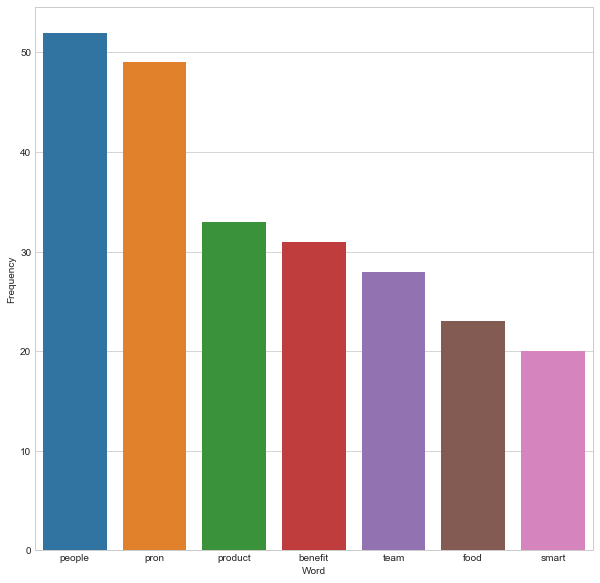

In [15]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

# Word Cloud on Pros

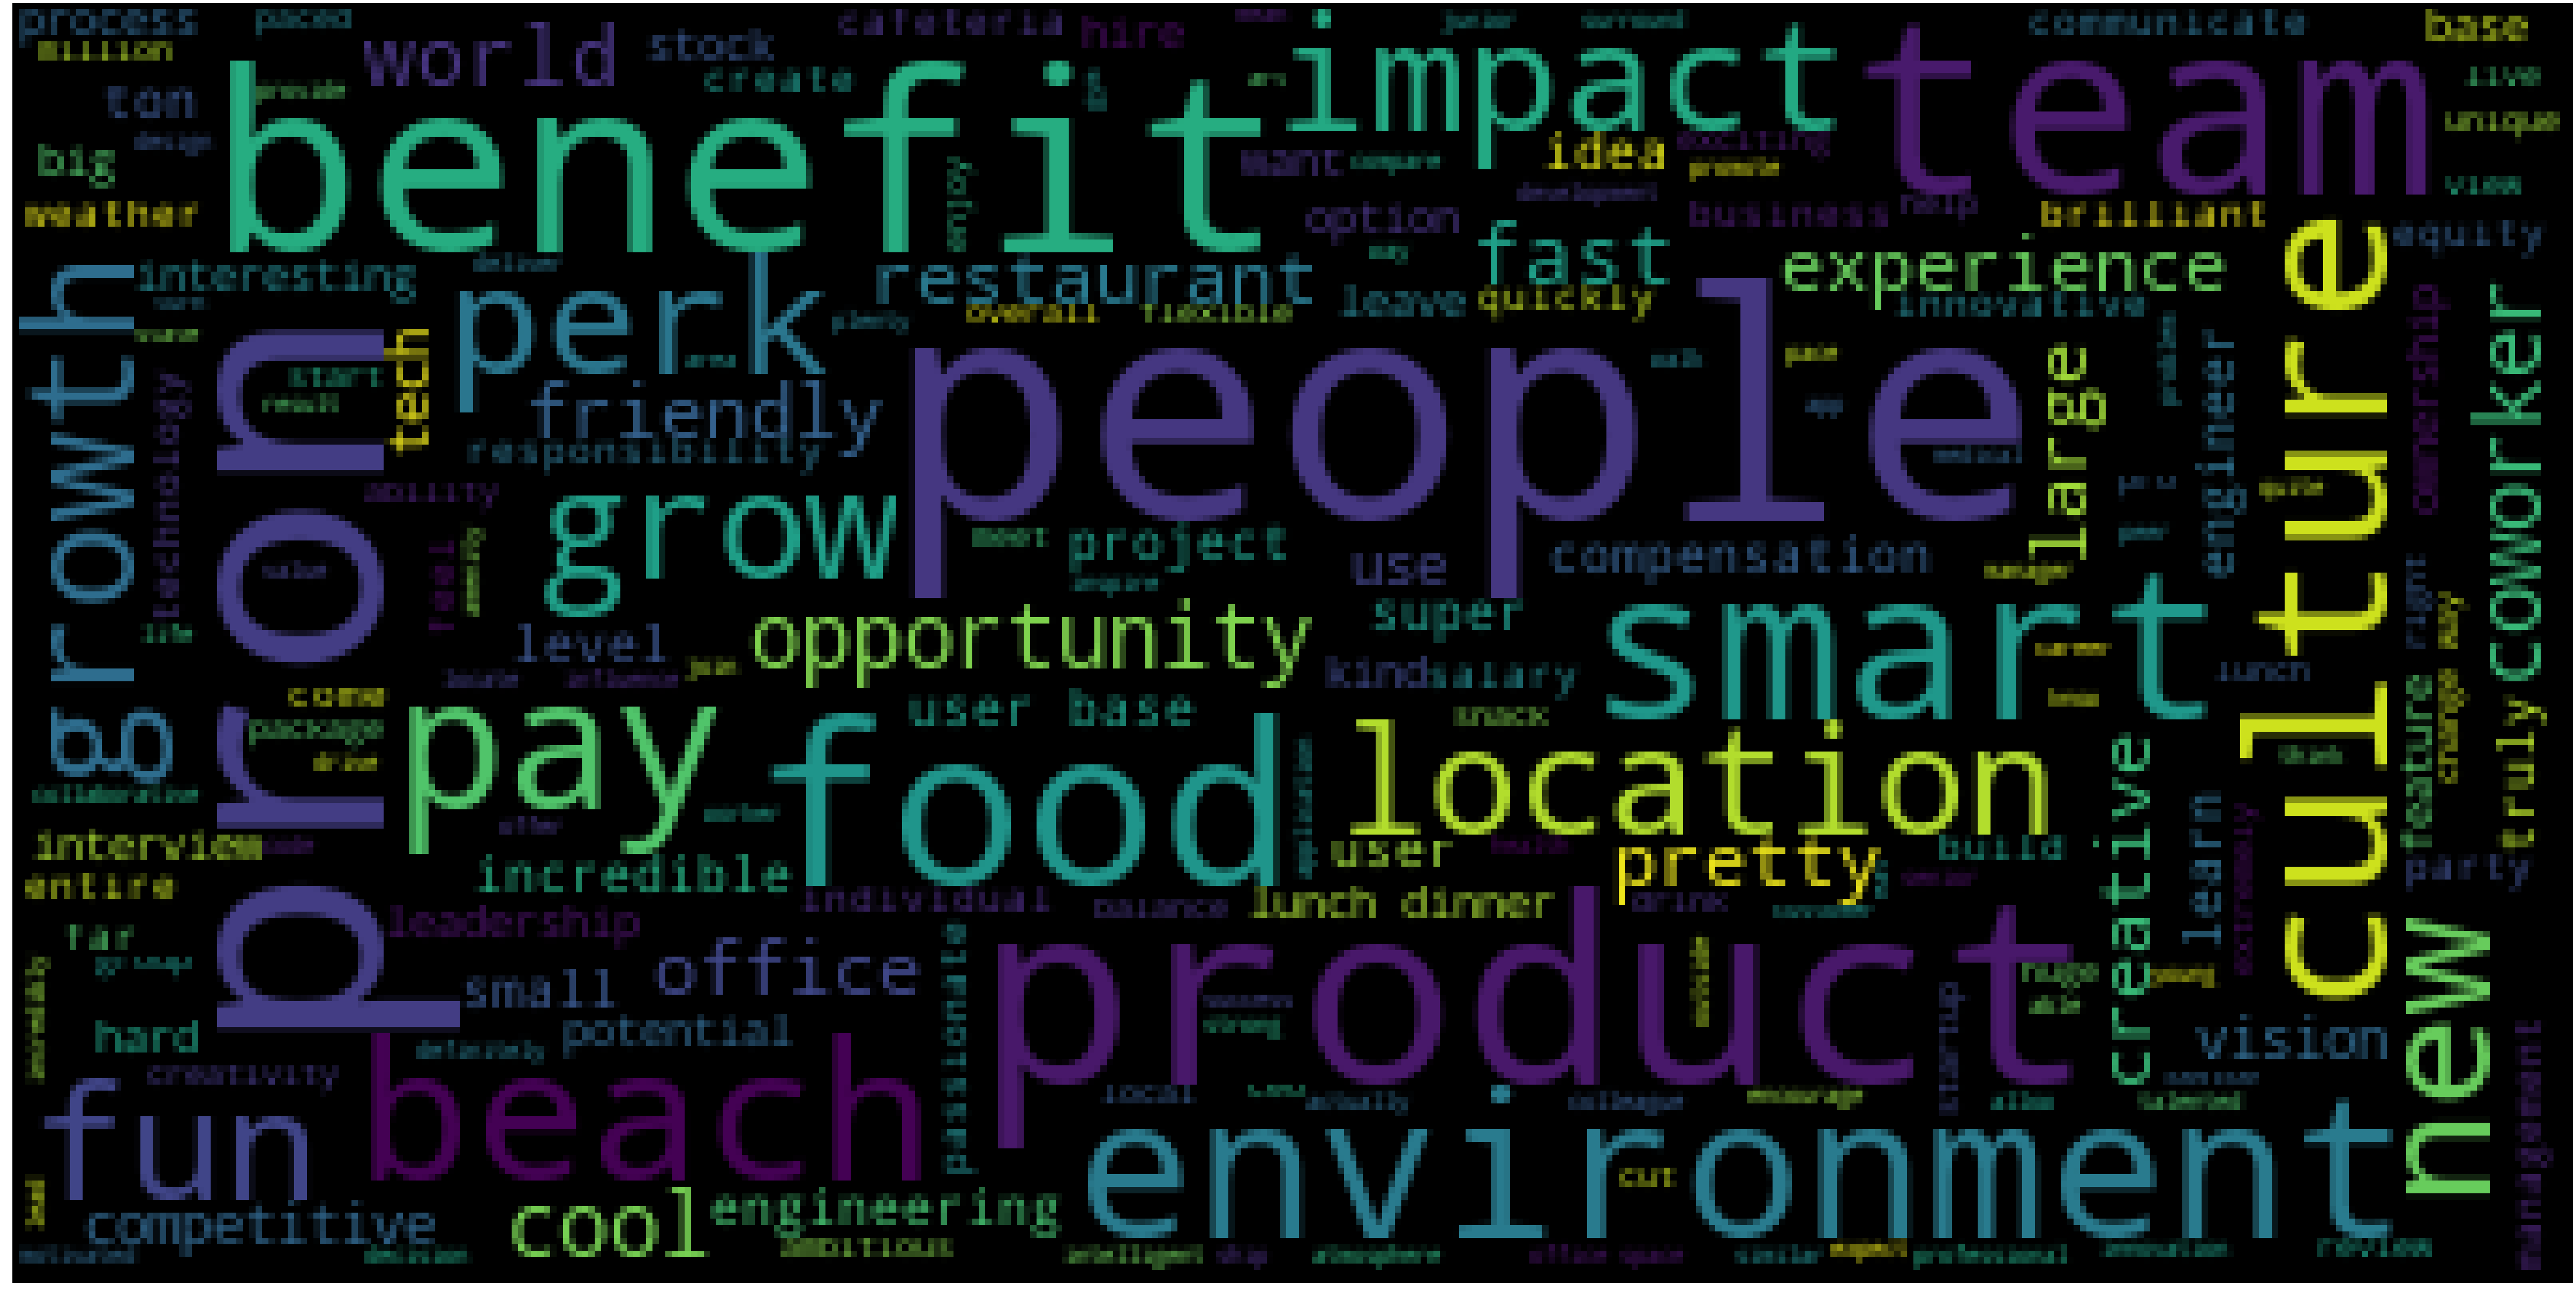

In [14]:
wc(cleaned_data_title,'black','Common Words' )

In [17]:
top_N = 100
#convert list of list into text
#a=''.join(str(r) for v in df_usa['title'] for r in v)

a = df['lem_con'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text
#stop_words = list(get_stop_words('en'))         
#nltk_words = list(stopwords.words('english'))   
#stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in STOPLIST]
filtered_sentence = []
for w in word_tokens:
    if w not in STOPLIST:
        filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

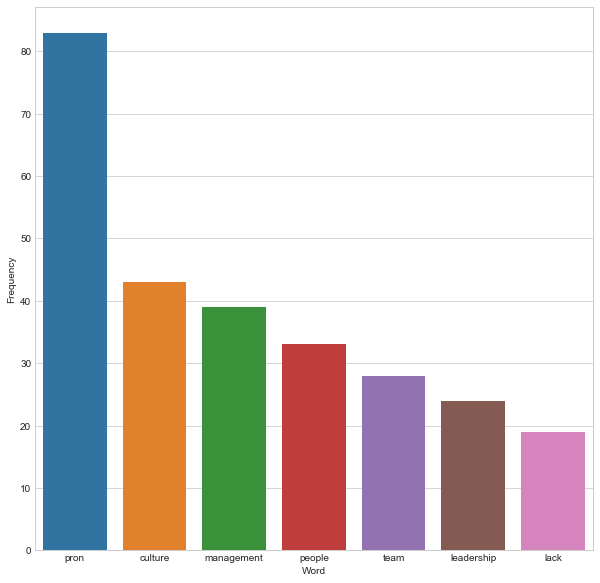

In [18]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

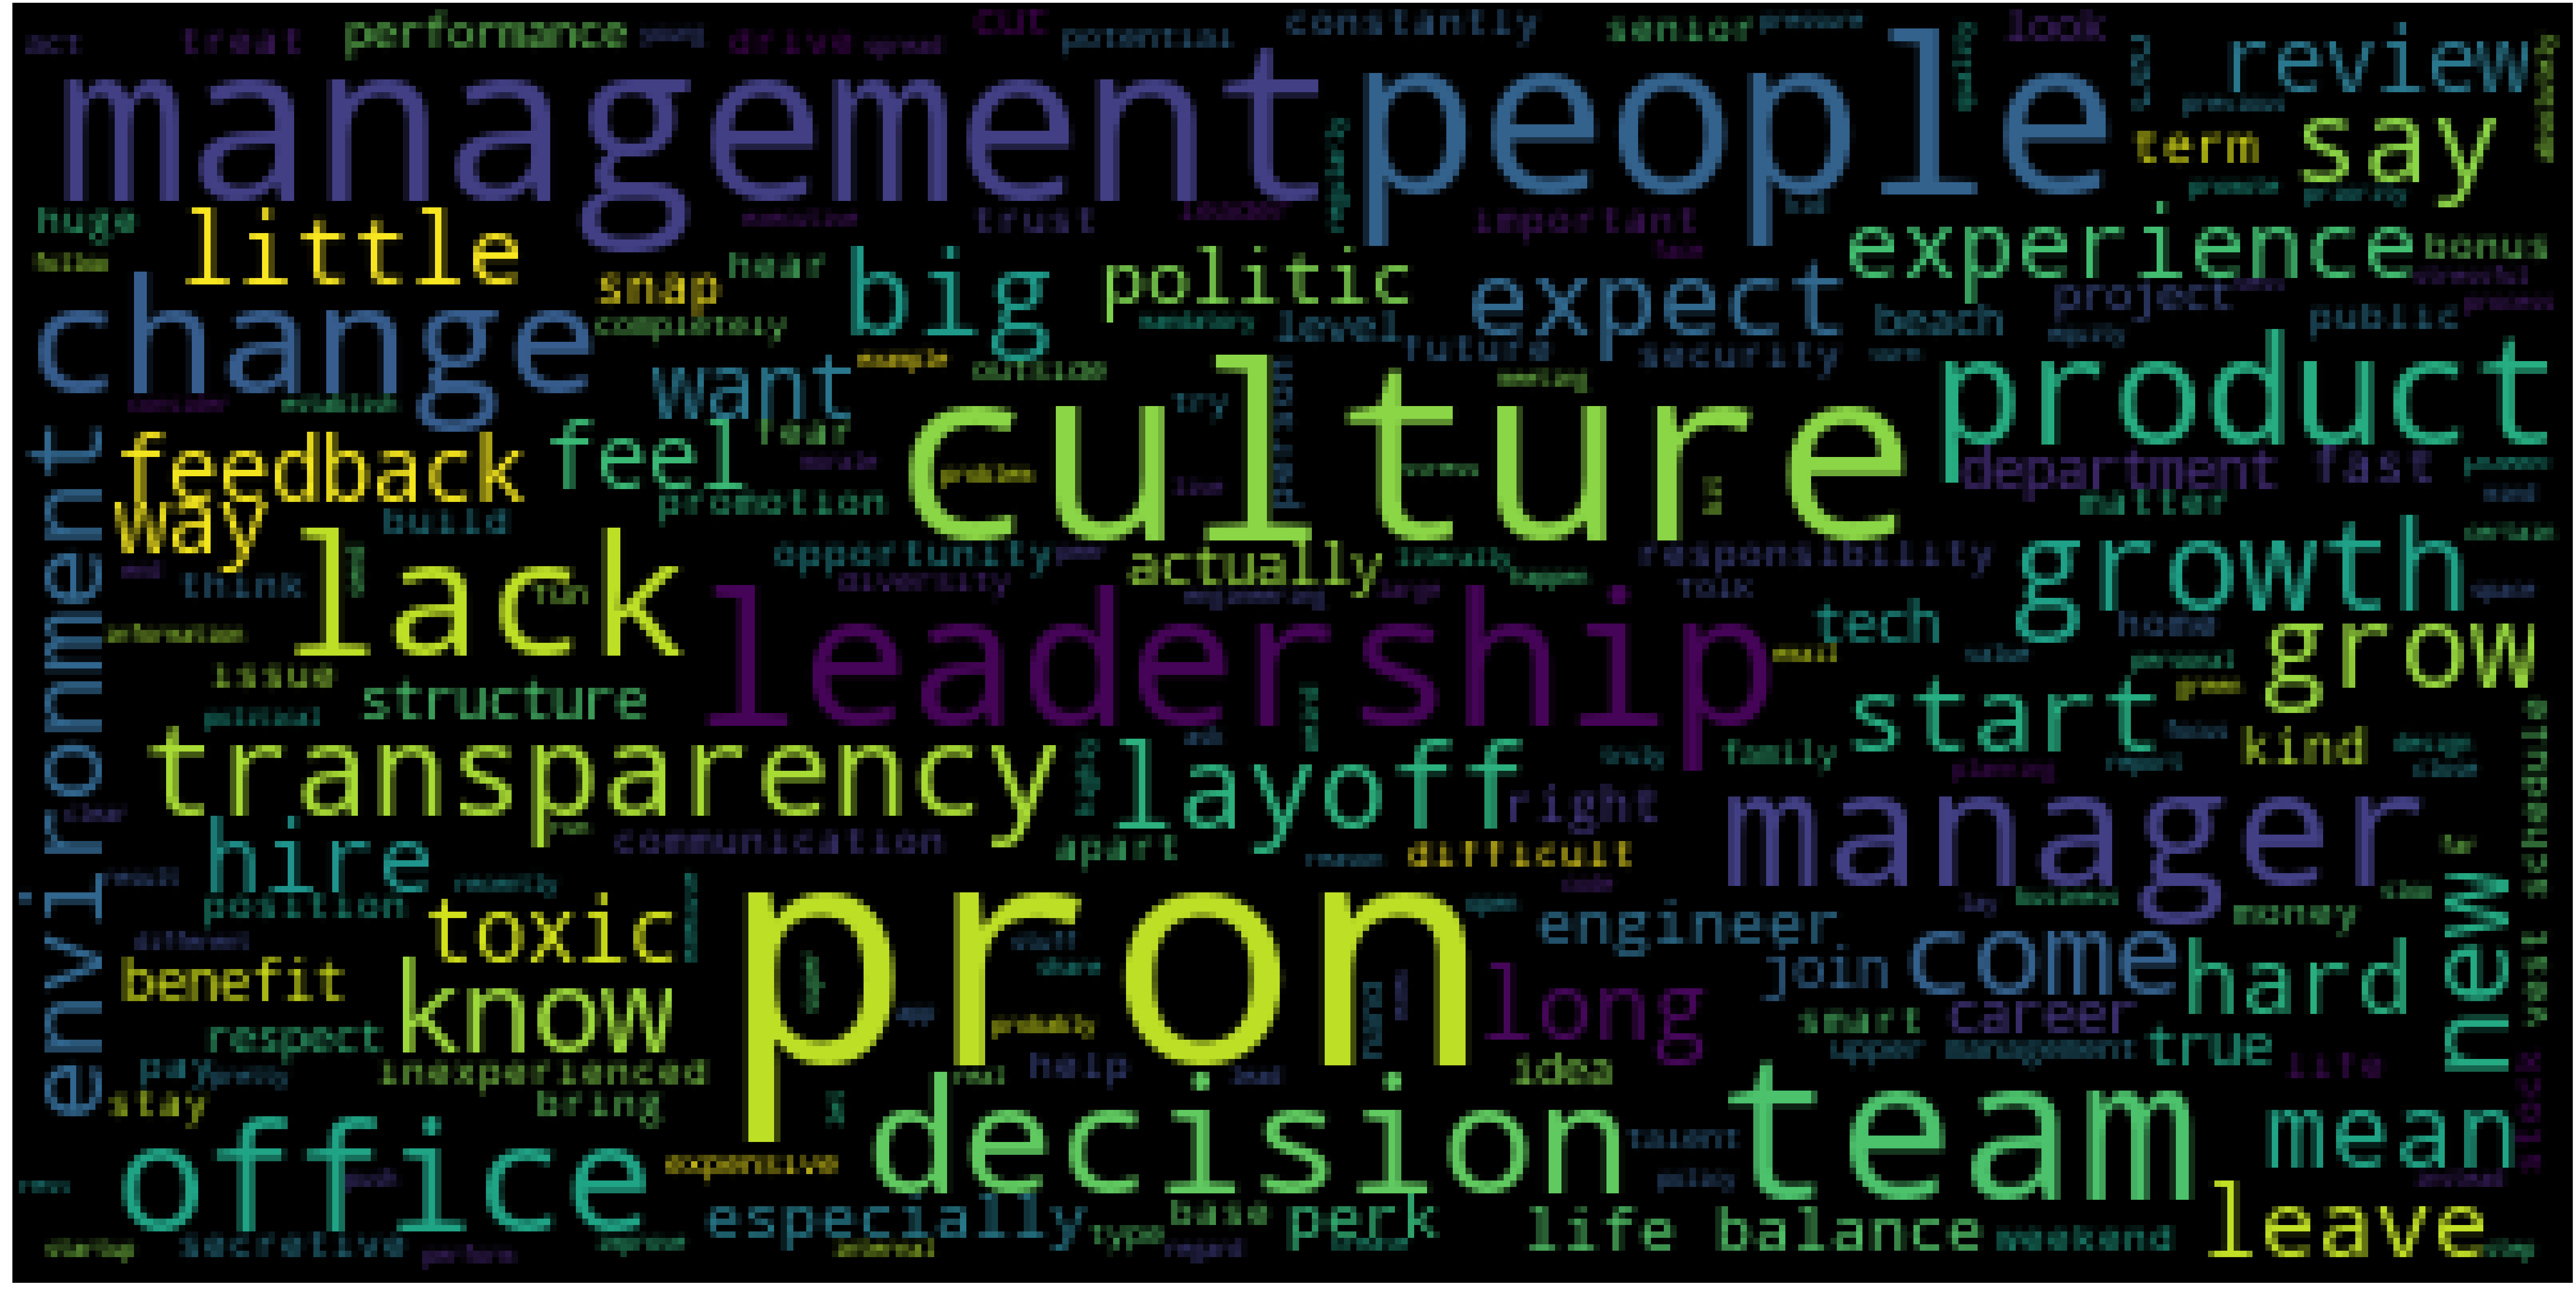

In [19]:
wc(cleaned_data_title,'black','Common Words' )

# Analyze sentiment of positive reviews

In [20]:
from textblob import TextBlob

In [31]:
txt_pro = df['pro'].str.lower().str.cat(sep=' ')
blob = TextBlob(txt_pro)
print (blob)

morale is high, and they take care of you. free food, learning opportunities every day. people are great and team environment is approachable. working environment is good. the pay is satisfactory great people, office, and benefits great benefits. perfect mix of people and results focus. how many companies are keeping zuck awake at night? one. once in a lifetime opportunity to see your ideas grow into a global business. seriously, this is the best place i have ever worked! everyone here is extremely creative and driven to produce the best products and customer experience for our users. each individual has a ton of responsibility and is able to truly impact the business. the culture here is amazing; free bfast, lunch and dinner and everything else you could ever want. the company cares a lot about it's employees and it shows through perks and activities. great company culture, amazing benefits, opportunities for growth -20/hr for remote work, very flexible -if you're in venice, working o

In [32]:
blob.sentiment

Sentiment(polarity=0.29130499846760893, subjectivity=0.5942892902738043)

In [33]:
txt_con = df['con'].str.lower().str.cat(sep=' ')
blob = TextBlob(txt_con)
print (blob)

work/life balance can be hectic. people enjoy coming in later which means a lot of the stuff gets done towards the end of the day. having kids is difficult with snaps schedule. not enough people working on research loose structure, company is under-performing fast paced. you have to be your own advocate. most people have been at snap for less than a year or two. still very "start up" like; however, this opens up amazing opportunities for individual contributors to step up and do awesome things. no cons to share! -not a lot of room for mobility -mgmt is terrible and seemingly a product of nepotism and not achievement-lack of cross-functional communication and a general lack of transparency-constantly reacting to things instead of proactively addressing issues and innovating.-consistent decline in morale during my time and no sign of improvement-office culture is truly toxic-the perks and benefits are great but at the end of the day just a distraction from a mediocre job - leadership is 

In [34]:
blob.sentiment

Sentiment(polarity=0.03782002935574362, subjectivity=0.5092413975271126)